In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

%matplotlib inline

In [31]:
hrEmployeeData = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv', dtype={'BusinessTravel': str})
xAxis = 'JobInvolvement'
yAxis = 'MonthlyRate'

(0, 31048.849999999999)

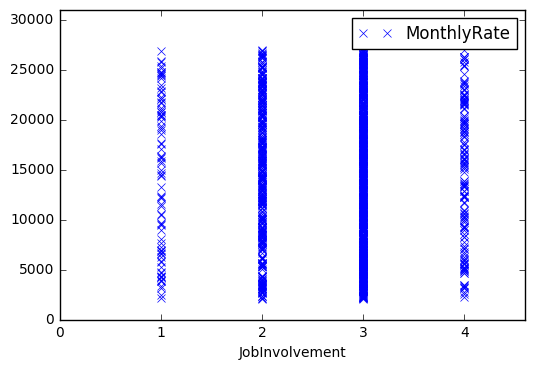

In [32]:
promotionVsHourly = hrEmployeeData.plot(x=xAxis, y=yAxis, style='x')
promotionVsHourly.set_xlim(0, hrEmployeeData[xAxis].max() * 1.15)
promotionVsHourly.set_ylim(0, hrEmployeeData[yAxis].max() * 1.15)

In [33]:
hrData = hrEmployeeData.as_matrix([xAxis, yAxis])

## Convert Categorical Data to Dummy Variables

In [34]:
def categoricalColumnNames(columnName, attributeList):
    return ['{}_{}'.format(columnName, attribute)
            for attribute in attributeList]

# Convert nominal variable x to its dummy vector variable representation
def _convertNominalVariable(dataFrame, columnName):
    attrValues = dataFrame[columnName].unique()
    newColumns = categoricalColumnNames(columnName, attrValues)
    encodingList = [np.zeros(len(attrValues) - 1) for attr in attrValues]
    
    for newColumn, value in zip(newColumns, attrValues):
        dataFrame[newColumn] = pd.Series()
        dataFrame.loc[dataFrame[columnName] == value, newColumn] = 1
        dataFrame.loc[dataFrame[columnName] != value, newColumn] = 0
    
    for i in range(1, len(attrValues)):
        encodedAttr = encodingList[i]
        encodedAttr[i - 1] = 1
    
    return dataFrame


def convertNominalVariables(dataFrame, columnList):
    newDf = pd.DataFrame(dataFrame)
    
    for attribute in columnList:
        newDf = _convertNominalVariable(newDf, attribute)
    return newDf
        
    
# Convert ordinal variable x to its dummy vector variable representation
def _convertOrdinalVariable(dataFrame, columnName, orderedAttributes):
    oneHotDf = _convertNominalVariable(dataFrame, columnName)
    newAttrNames = categoricalColumnNames(columnName, orderedAttributes)
    print(newAttrNames)
    attrIndices = {}
    
    for i, attr in enumerate(orderedAttributes):
        attrIndices[attr] = i
    
    for i, newOldAttr in enumerate(zip(orderedAttributes, newAttrNames)):
        oldAttr, newAttr = newOldAttr
        print('Checking for {}. Setting [{}] to 1'.format(oldAttr, newAttrNames[:i + 1]))
        for attrName in newAttrNames[:i]:
            oneHotDf.loc[oneHotDf[columnName] == oldAttr, attrName] = 1
    return oneHotDf

    
# newDf = pd.get_dummies(hrEmployeeData, columns=['EducationField'])
convertedDf = convertNominalVariables(hrEmployeeData, ['EducationField'])
# print(convertedDf)

# print(newDf)
# print(hrEmployeeData['EducationField'].unique())
# _convertOrdinalVariable(hrEmployeeData, 'EducationField', ['Life Sciences', 'Other', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources'])

## Linear Regression Functions

In [35]:
"""
inputVals: vector in form of [x1, x2, ..., xn]
beta: vector of beta coefficients in form [b0, b1, b2, ..., bn]
"""
def linRegEstimate(inputVals, beta):
    inputMatrix = np.insert(inputVals, 0, 1)
#     print('input values:', inputVals)
#     print('input matrix:', inputMatrix)
#     print('multiply:', inputMatrix * beta)
    return np.sum(inputMatrix * beta)


"""
matrix: matrix of points in form [[x1, x2, ..., xn], ...]
returns: (beta, pearsonCorrelation) tuple
"""
def computeLinRegBeta(x, y):
    # Reshape 1-D arrays to column format
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
        
    m = len(x)
#     print('X.shape: {}, X: {}'.format(x.shape, x))
#     print('Y:', y)
    newX = np.insert(x, 0, np.ones(m), axis=1)
#     print('NewX:', newX)
    newY = y.reshape(-1, 1)
#     print('NewY:', newY)
    beta = np.linalg.inv(newX.T.dot(newX)).dot(newX.T).dot(newY)
#     print('Beta:', beta.T)
#     print('NewX.T[1]:', x.T)
#     print('NewY.T[0]:', y)
    return beta.T[0], np.corrcoef(x.T, newY.T[0])[0, 1] ** 2

## Check R^2 to SciPy results

In [36]:
def checkR2(x, y):
    slope, intercept, r2, p_val, std_err = stats.linregress(x, y)
    print('slope={}, intercept={}, R2={}'.format(slope, intercept, r2 ** 2))

In [37]:
testInput = np.array([[1, 6], [2, 5], [3, 7], [4, 10]])
coefficients, correlation = computeLinRegBeta(testInput[:, 0], testInput[:, 1])
print('Coefficients: {}, R2: {}'.format(coefficients, correlation))
checkR2([1, 2, 3, 4], [6, 5, 7, 10])

Coefficients: [ 3.5  1.4], R2: 0.7000000000000001
slope=1.4, intercept=3.5, R2=0.7000000000000001


In [38]:
linRegEstimate([3], coefficients)

7.7000000000000037

In [39]:
businessTravelDf = _convertOrdinalVariable(hrEmployeeData,
                                           'BusinessTravel',
                                           ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'])
busTravColumns = categoricalColumnNames('BusinessTravel', ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'])
busTravColumns += [yAxis]
print('Getting columns:', busTravColumns)
busTravelData = businessTravelDf.as_matrix(busTravColumns)
busTravBeta, busTravR2 = computeLinRegBeta(busTravelData[:, :-1], busTravelData[:, -1])

print('Business travel data:', busTravelData)
print('Business travel beta: {}, R2: {}'.format(busTravBeta, busTravR2))
# busTravelBeta, busTravR2 = computeLinRegBeta(businessTravelDf.as_matrix(['BusinessTravel']))

hrBeta, hrCorrelation = computeLinRegBeta(hrData[:, 0], hrData[:, 1])
print('HR Pearson Correlation coefficient:', hrCorrelation)

['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Rarely', 'BusinessTravel_Travel_Frequently']
Checking for Non-Travel. Setting [['BusinessTravel_Non-Travel']] to 1
Checking for Travel_Rarely. Setting [['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Rarely']] to 1
Checking for Travel_Frequently. Setting [['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Rarely', 'BusinessTravel_Travel_Frequently']] to 1
Getting columns: ['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Rarely', 'BusinessTravel_Travel_Frequently', 'MonthlyRate']
Business travel data: [[  1.00000000e+00   1.00000000e+00   0.00000000e+00   1.94790000e+04]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00   2.49070000e+04]
 [  1.00000000e+00   1.00000000e+00   0.00000000e+00   2.39600000e+03]
 ..., 
 [  1.00000000e+00   1.00000000e+00   0.00000000e+00   5.17400000e+03]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00   1.32430000e+04]
 [  1.00000000e+00   1.00000000e+00   0.00000000e+00   1.02280000e+0

# Air Quality UCI Set
## Clean the data

In [40]:
convertEuropeanFloats = lambda val: float(val.replace(',', '.'))
airQualityDf = pd.read_csv('data/AirQualityUCI.csv', sep=';',
                           converters={
        'CO(GT)': convertEuropeanFloats,
        'C6H6(GT)': convertEuropeanFloats,
        'T': convertEuropeanFloats,
        'RH': convertEuropeanFloats
    })
airQualityDf.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)

columnNamesByType = airQualityDf.columns.to_series().groupby(airQualityDf.dtypes).groups
columnNamesByType = {key.name: val for key, val in columnNamesByType.items()}
airQualityXColNames = [col for col in columnNamesByType['float64'] + columnNamesByType['int64']
                      if col != 'CO(GT)']
airQualityDf.drop(airQualityDf[airQualityDf['CO(GT)'] == -200.0].index, inplace=True)
# airQualityDf.drop(airQualityDf[airQualityDf['PT08.S3(NOx)'] == -200.0].index, inplace=True)

for xCol in airQualityXColNames:
    print('Dropping missing rows from', xCol)
    # -200 means missing value
    airQualityDf.drop(airQualityDf[airQualityDf[xCol] == -200.0].index, inplace=True)

Dropping missing rows from C6H6(GT)
Dropping missing rows from T
Dropping missing rows from RH
Dropping missing rows from PT08.S1(CO)
Dropping missing rows from NMHC(GT)
Dropping missing rows from PT08.S2(NMHC)
Dropping missing rows from NOx(GT)
Dropping missing rows from PT08.S3(NOx)
Dropping missing rows from NO2(GT)
Dropping missing rows from PT08.S4(NO2)
Dropping missing rows from PT08.S5(O3)


In [41]:
airQualityY = airQualityDf['CO(GT)']
airQualityXCols = [airQualityDf[attr]
                   for attr in airQualityXColNames]

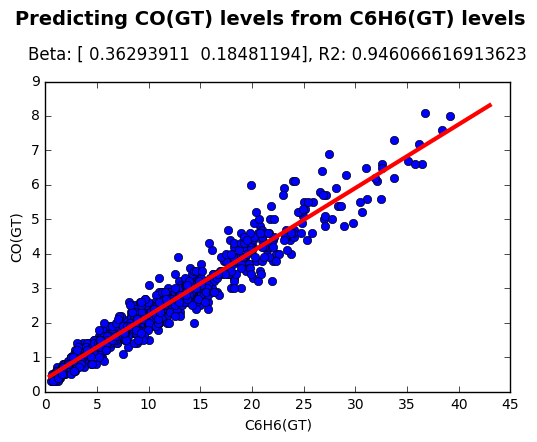

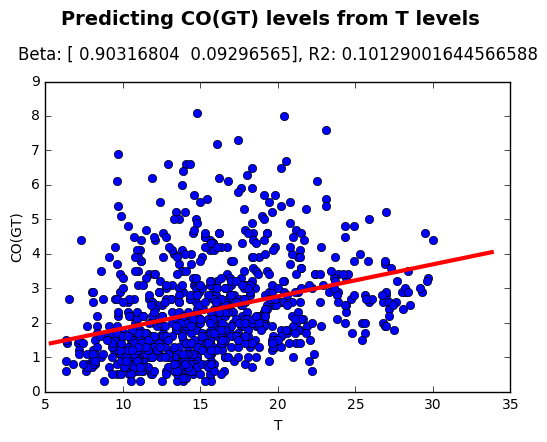

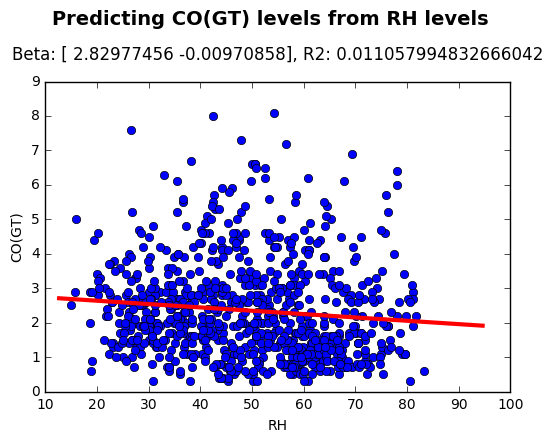

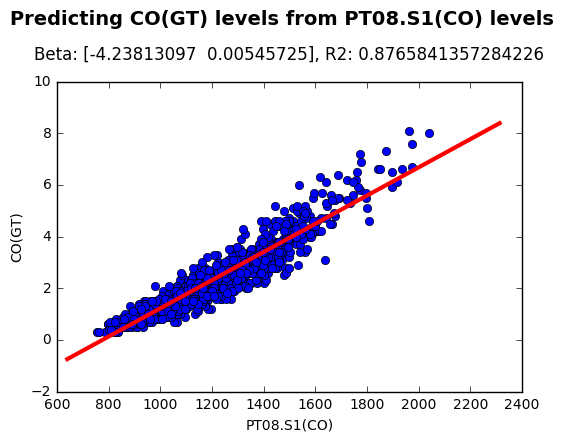

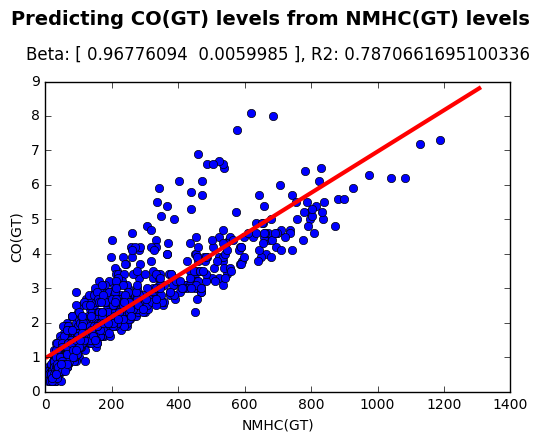

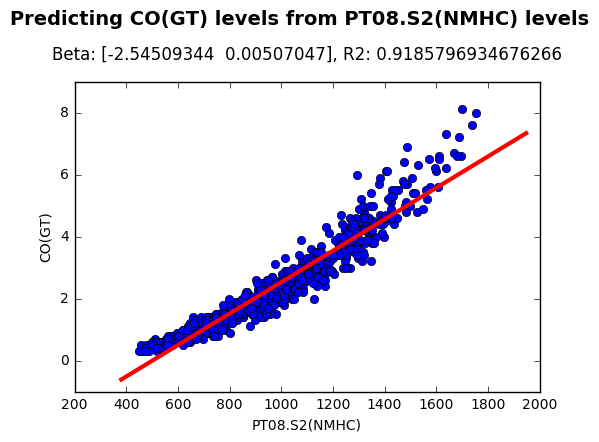

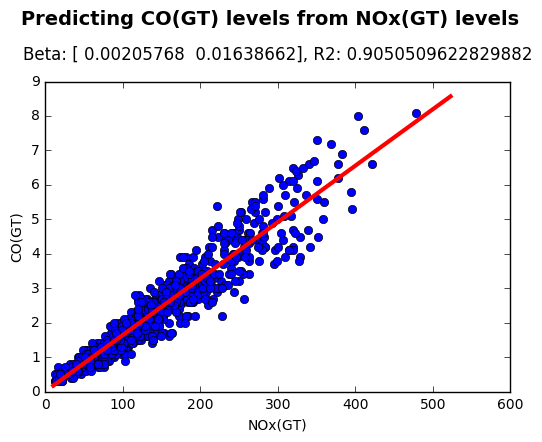

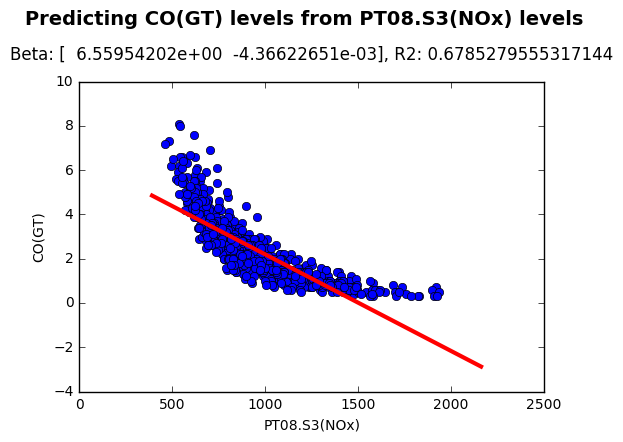

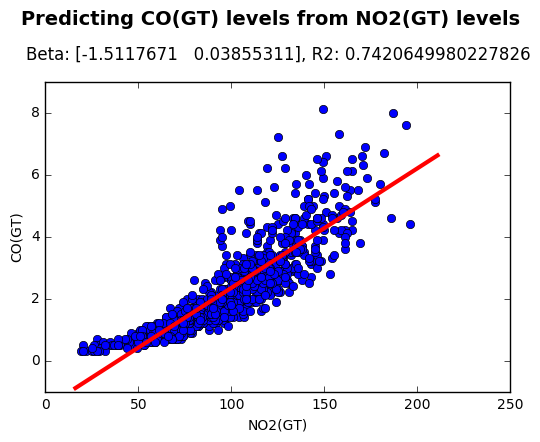

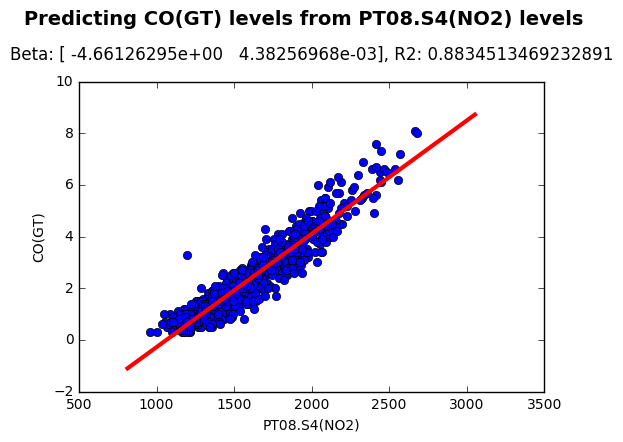

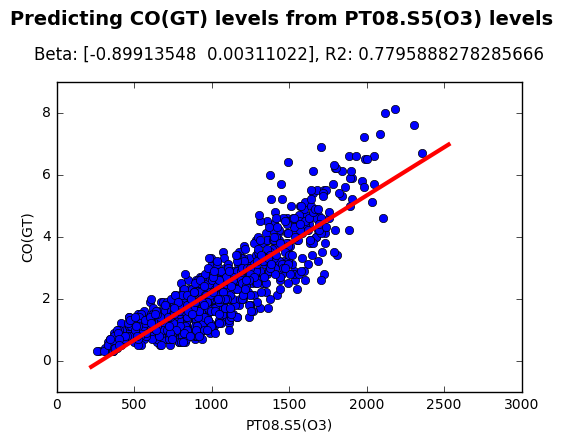

In [42]:
COValues = airQualityDf['CO(GT)'].as_matrix()

for col in airQualityXCols:
    colValues = col.as_matrix()
    colBetas, colCorrelation = computeLinRegBeta(colValues, COValues)

    xMin = colValues.min()
    xMax = colValues.max()
    xRange = np.arange(xMin * .85, xMax * 1.15, (xMax - xMin) / 10)
    predictedLine = [linRegEstimate([x], colBetas) for x in xRange]

    fig = plt.figure()
    graph = fig.add_subplot(111)
    fig.suptitle('Predicting {} levels from {} levels'.format(airQualityY.name, col.name),
                y=1.08, fontsize=14, fontweight='bold')
    graph.set_title('Beta: {}, R2: {}'.format(colBetas, colCorrelation))
    graph.title.set_position([0.5, 1.05])
    graph.set_ylabel(airQualityY.name)
    graph.set_xlabel(col.name)
    graph.plot(colValues, COValues, 'bo', xRange, predictedLine, 'r-', linewidth=3.0)

## Predicting CO Concentration from C6H6 (Benzene) Concentration
### Benzene is a highly flammable core component of gasoline

C6H6(GT) to predict CO(GT) R^2: 0.946066616914
C6H6(GT) to CO(GT) beta: [ 0.36293911  0.18481194]


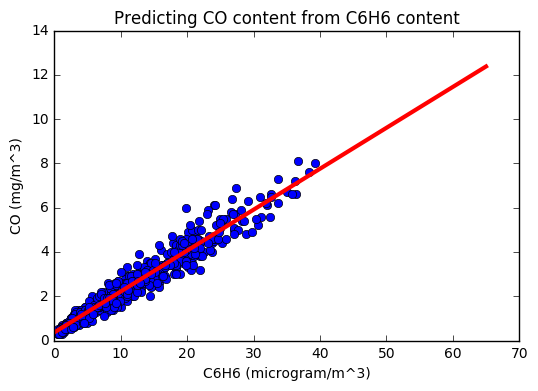

In [43]:
c6h6GTValues = airQualityDf['C6H6(GT)'].as_matrix()
# COValues = airQualityDf['CO(GT)'].as_matrix()
c6h6VsCOBetas, c6h6VsCOCorrelation = computeLinRegBeta(c6h6GTValues, COValues)
print('C6H6(GT) to predict CO(GT) R^2:', c6h6VsCOCorrelation)
print('C6H6(GT) to CO(GT) beta:', c6h6VsCOBetas)

xRange = np.arange(0, 70, 5)
predictedLine = [linRegEstimate([c6h6], c6h6VsCOBetas) for c6h6 in xRange]

plt.plot(c6h6GTValues, COValues, 'bo', xRange, predictedLine, 'r-', linewidth=3.0)
plt.title('Predicting CO content from C6H6 content')
plt.xlabel('C6H6 (microgram/m^3)')
plt.ylabel('CO (mg/m^3)')

# 2 Variable Regression
## Predicting CO Levels from Benzene and Titania (PT08.S2) Levels

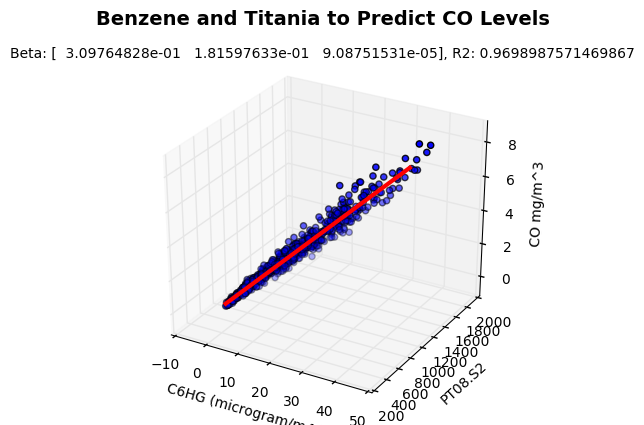

In [44]:
benzenePT08 = airQualityDf[['C6H6(GT)', 'PT08.S2(NMHC)']].as_matrix()
benzenePT08Betas, benzenePT08Correlation = computeLinRegBeta(benzenePT08, COValues)

benzeneMin = benzenePT08[:, 0].min()
benzeneMax = benzenePT08[:, 0].max()
PT08Min = benzenePT08[:, 1].min()
PT08Max = benzenePT08[:, 1].max()

benzeneDomain = np.arange(benzeneMin, benzeneMax, (benzeneMax - benzeneMin) / 10)
PT08Domain = np.arange(PT08Min, PT08Max, (PT08Max - PT08Min) / 10)
benzenePT08Domains = np.array([benzeneDomain, PT08Domain]).T
benzenePT08PredictedCO = [linRegEstimate(xy, benzenePT08Betas)
                          for xy in benzenePT08Domains]

fig = plt.figure()
fig.suptitle('Benzene and Titania to Predict CO Levels',
             y=1.05, fontsize=14, fontweight='bold')
benzPT08Plot = fig.add_subplot(111, projection='3d')
benzPT08Plot.scatter(benzenePT08[:, 0], benzenePT08[:, 1], COValues)
benzPT08Plot.plot(benzeneDomain, PT08Domain, benzenePT08PredictedCO, 'r-', linewidth=3.0)
benzPT08Plot.set_title('Beta: {}, R2: {}'.format(benzenePT08Betas, benzenePT08Correlation),
                      y=1.05, fontsize=10)
benzPT08Plot.set_xlabel('C6HG (microgram/m^3)')
benzPT08Plot.set_ylabel('PT08.S2')
benzPT08Plot.set_zlabel('CO mg/m^3')

plt.tight_layout()